In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
root = '/content/drive/MyDrive/lab1/dataset'

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_data_gen = ImageDataGenerator(rescale = 1./255)

Loading dataset

In [36]:
def loadData(url):
    return image_gen.flow_from_directory(
      url,
      target_size=(500, 500),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=16
      )

train = loadData(root + '/train')
test = loadData(root + '/test')
val = loadData(root + '/val')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Creating Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

model = Sequential()

def addLayer(filters):
    model.add(Conv2D(filters, (3, 3), activation="relu", input_shape=(500, 500, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
addLayer(32)
addLayer(32)
addLayer(32)
addLayer(64)
addLayer(64)
model.add(Flatten())
model.add(Dense(activation = 'relu', units = 128))
model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(activation = 'sigmoid', units = 1))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

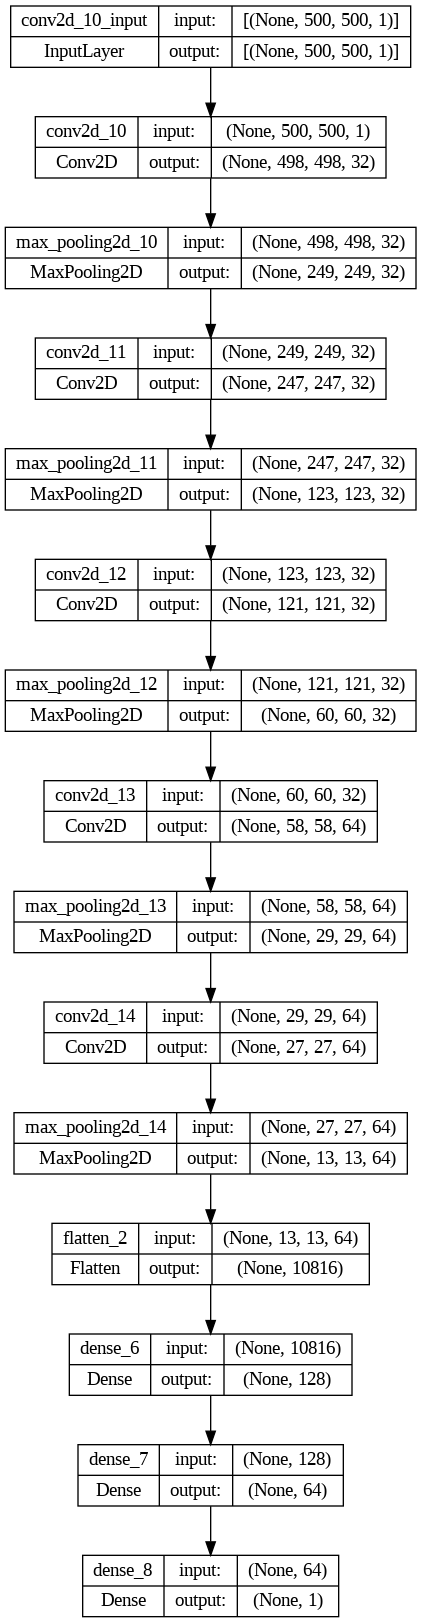

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [34]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [37]:
import torch
from sklearn.utils.class_weight import compute_class_weight
unique_classes = np.unique(train.classes)
class_counts = np.bincount(train.classes)
total_samples = len(train.classes)

class_weights = {}
for cls in unique_classes:
    class_weight = total_samples / (len(unique_classes) * class_counts[cls])
    class_weights[cls] = class_weight


class_weights = [class_weights[i] for i in range(len(class_weights))]
class_weights = torch.FloatTensor(class_weights).cuda() if torch.cuda.is_available() else torch.FloatTensor(class_weights)
cw = dict(zip( np.unique(train.classes), class_weights))
cw_numeric = {cls: weight.item() for cls, weight in cw.items()}
cw_numeric

{0: 1.944817304611206, 1: 0.673032283782959}

Training Model

In [40]:
model.fit(train,epochs=1, validation_data=val, class_weight=cw_numeric, callbacks=callbacks_list)

326/326 [==============================] - 192s 578ms/step - loss: 0.3675 - accuracy: 0.8278 - val_loss: 1.5034 - val_accuracy: 0.6875 - lr: 0.0010


<Axes: >

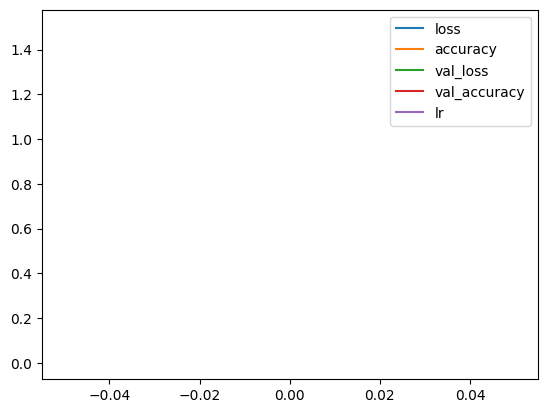

In [42]:
pd.DataFrame(model.history.history).plot()

In [43]:
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 17s 429ms/step - loss: 0.4266 - accuracy: 0.8157
The testing accuracy is : 81.57051205635071 %


In [44]:
preds = model.predict(test,verbose=1)

39/39 [==============================] - 17s 424ms/step


Decision Boundary 0.5

In [45]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

Performance

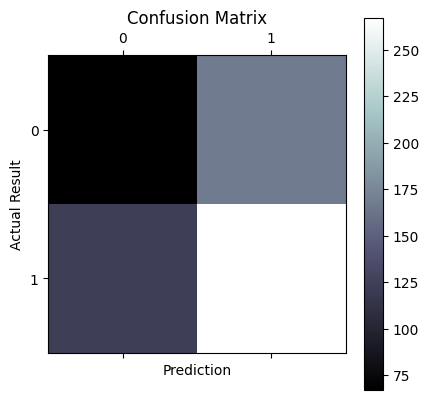

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

c_matrix = confusion_matrix(test.classes, predictions)

plt.matshow(c_matrix, cmap=plt.cm.bone)
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual Result")
plt.show()

In [56]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.35      0.29      0.32       234
   PNEUMONIA       0.62      0.68      0.65       390

    accuracy                           0.54       624
   macro avg       0.48      0.49      0.48       624
weighted avg       0.52      0.54      0.52       624



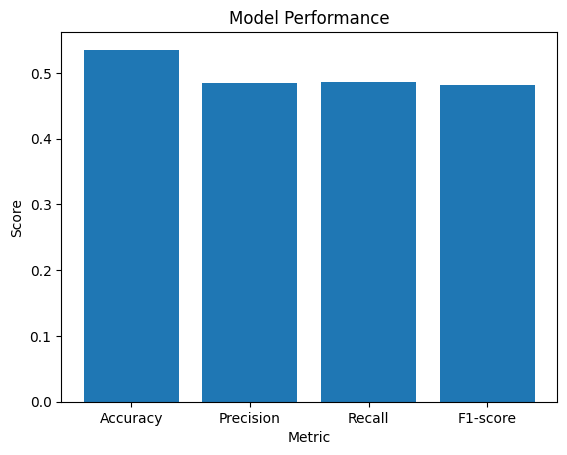

In [51]:
accuracy = accuracy_score(test.classes, predictions)
precision = precision_score(test.classes, predictions, average='macro')
recall = recall_score(test.classes, predictions, average='macro')
f1_score = f1_score(test.classes, predictions, average='macro')

metrics = [accuracy, precision, recall, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']

plt.bar(labels, metrics)
plt.title("Model Performance")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()